# Neural Networks Fundamentals - Gradient Descent
This project is part of the (cannot excplicitly name it) course at TU Eindhoven. It focuses on the fundamentals of neural networks, with an emphasis on implementing a Multi-Layer Perceptron (MLP) to classify digits from the MNIST dataset. You will work with fully-connected layers, activation functions (ReLU and Sigmoid), and mini-batch SGD with cross-entropy loss. The project also involves analyzing the model’s performance, calculating trainable parameters, and experimenting with different loss functions such as Cross-Entropy, Dice, and Focal Loss to enhance accuracy.

### Running Code
Using course provided "experiments" environment is recommended.

### Variables explanation
- **W1**: Weights for the first layer (input to hidden layer)
- **b1**: Bias for the first layer
- **W2**: Weights for the second layer (hidden to output layer)
- **b2**: Bias for the second layer
- **A1**: Activation of the first layer (output after applying activation function to Z1)
- **A2**: Output of the network (after applying softmax activation function to Z2)
- **Z1**: Linear transformation for the first layer (W1.dot(values) + b1)
- **Z2**: Linear transformation for the second layer (W2.dot(A1) + b2)
- **m**: Number of training examples (samples in the training set)
- **n**: Number of features (including labels)
- **values**: Input features (e.g., pixel values for MNIST images)
- **labels**: Ground truth labels (e.g., corresponding digit labels for MNIST images)
- **dW1**: Gradient of the weights for the first layer
- **db1**: Gradient of the bias for the first layer
- **dW2**: Gradient of the weights for the second layer
- **db2**: Gradient of the bias for the second layer
- **alpha**: Learning rate (step size for weight updates)

### Example Results

BGD(early implementation), epochs: 500, alpha: 0.1, activation: sigmoid\
training time: 600s, accuracy: 0.7, loss: 1.16
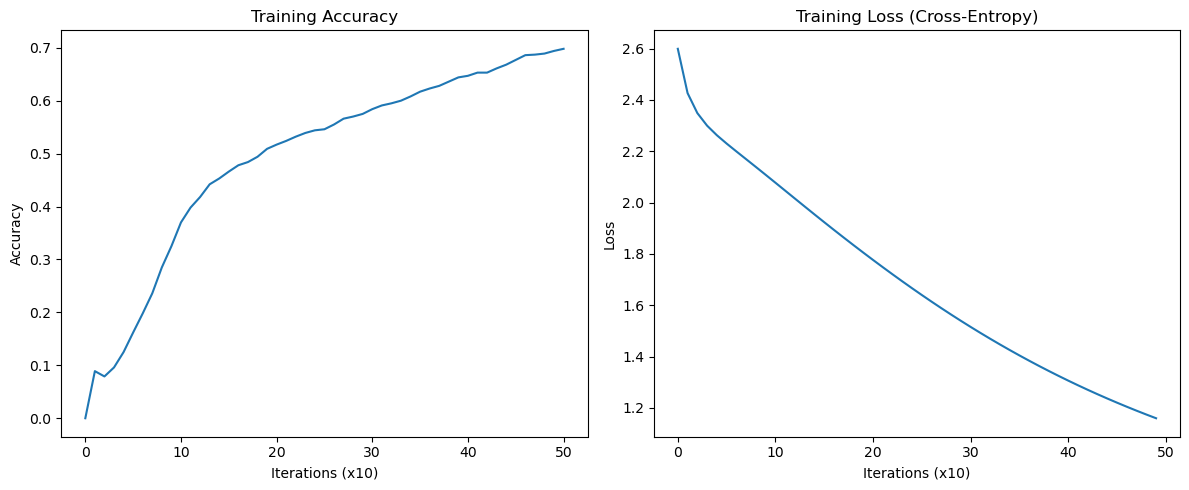

BGD, epochs: 2000,  alpha: 0.1,  activation: sigmoid\
training time: 3288s, accuracy: 0.902, loss: 0.337
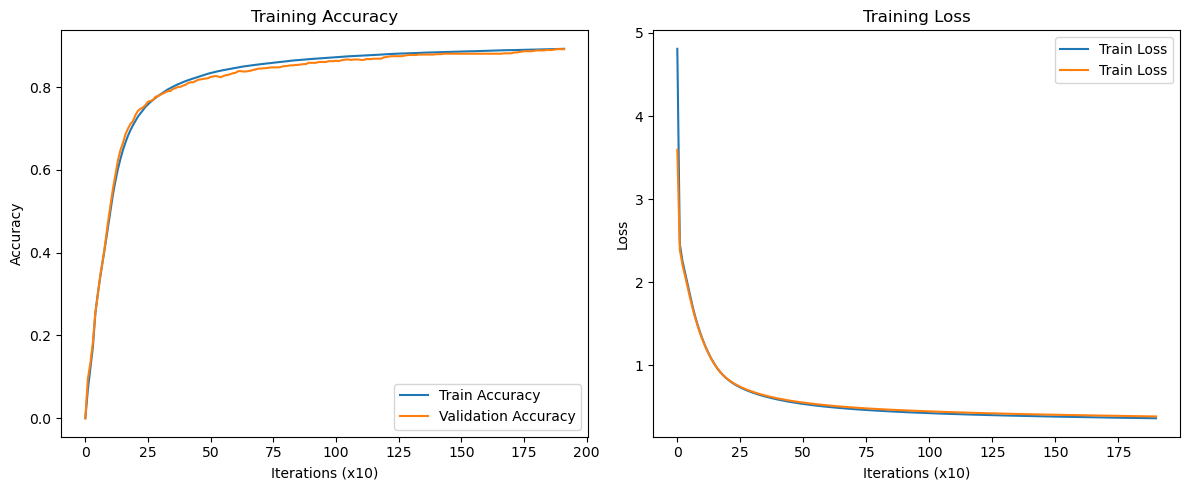

BGD, epochs: 2000,  alpha: 0.2,  activation: sigmoid\
training time: 4279s, accuracy: 0.909, loss: 0.299
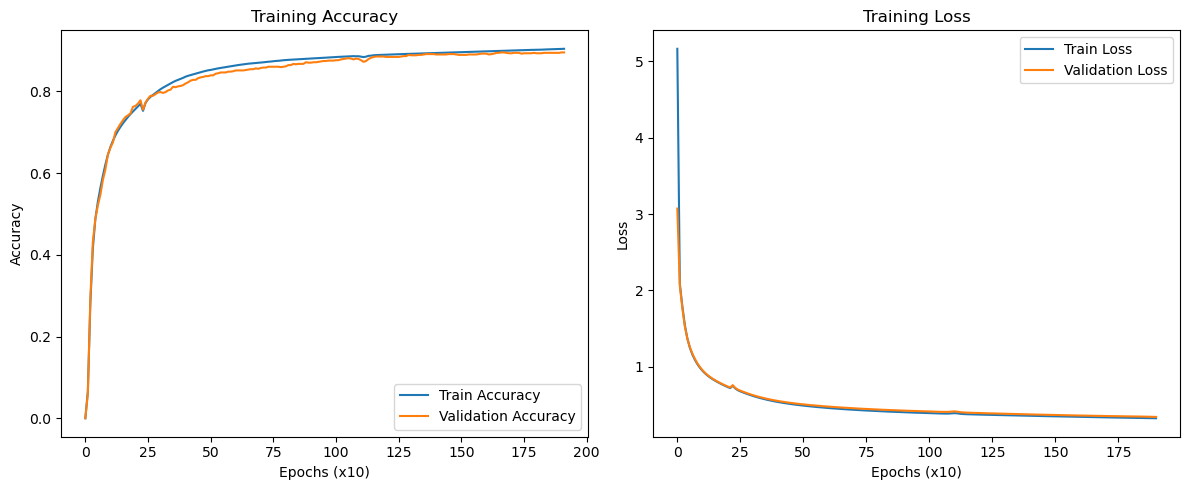

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

In [2]:
DEBUG = True # Used to display additional information during program execution
TEST_SIZE = 1000
VALIDATION_SIZE = 1000
ALPHA = 0.2
EPOCHS = 2000
TRAININIG_UPDATES = 10 #number of epochs after which trainiing update is printed
TRAINING_SHOW_UPDATES = 100 #number of epochs after which trainiing plot is shown

In [3]:
def show_image(values, index):
    """
    Display image selected by index from given values matrix
    """
    image = values[:, index, None]
    image = image.reshape((28,28)) * 255
    plt.gray()
    plt.imshow(image)
    plt.show()

In [4]:
#Load dataset from a file
data = pd.read_csv('Datasets/MNIST_CSV/mnist.csv', header=None)
if DEBUG:
    print(data.head())

   0    1    2    3    4    5    6    7    8    9    ...  775  776  777  778  \
0    5    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
1    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
2    4    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
3    1    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
4    9    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   

   779  780  781  782  783  784  
0    0    0    0    0    0    0  
1    0    0    0    0    0    0  
2    0    0    0    0    0    0  
3    0    0    0    0    0    0  
4    0    0    0    0    0    0  

[5 rows x 785 columns]


n = 785
m = 70000
labels_train.shape = (68000,)
values_train.shape = (784, 68000)
labels_test.shape = (1000,)
values_test.shape = (784, 1000)


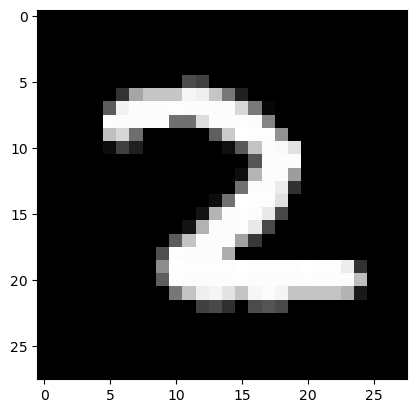

In [5]:
# Divide dataset to test, validation and train sets

data = np.array(data)
m, n = data.shape # n is amount of features including labels 

np.random.shuffle(data)

data_test = data[0:TEST_SIZE].T
labels_test = data_test[0]
values_test = data_test[1:n] / 255

data_validation = data[TEST_SIZE:(TEST_SIZE+ VALIDATION_SIZE)].T
labels_validation = data_validation[0]
values_validation = data_validation[1:n] / 255

data_train = data[(TEST_SIZE+VALIDATION_SIZE):m].T
labels_train = data_train[0]
values_train = data_train[1:n] / 255

if DEBUG:
    print("n =",n)
    print("m =",m)
    print("labels_train.shape =",labels_train.shape)
    print("values_train.shape =",values_train.shape)
    print("labels_test.shape =",labels_test.shape)
    print("values_test.shape =",values_test.shape)
    show_image(values_train, 1)

In [6]:
def init_params():
    """Initialize NN weights and biases"""
    W1 = np.random.rand(10,784) - 0.5
    b1 = np.random.rand(10,1) - 0.5

    W2 = np.random.rand(10,10) - 0.5
    b2 = np.random.rand(10,1) - 0.5
    return W1, b1, W2, b2

def ReLU(Z):
    """Calculate ReLu activation function"""
    return np.maximum(0, Z)

def sigmoid(Z):
    """Calculate Sigmoid activation function"""
    return 1 / (1 + np.exp(-Z))

def softmax(Z):
    """Calculate softmax of given vector Z"""
    Z -= np.max(Z, axis=0)
    A = np.exp(Z) / np.sum(np.exp(Z), axis=0)
    return A

def forward_propagation(W1, b1, W2, b2, values):
    """Pass through the NN input->output"""
    Z1 = W1.dot(values) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def one_hot(labels):
    """Perform one hot encoding returning a binary matrix based on provided labels"""
    # Class 0 -> [1,0,0,...]
    # Class 1 -> [0,1,0,...]
    # ...

    one_hot_labels = np.zeros((labels.size, labels.max() + 1))
    one_hot_labels[np.arange(labels.size), labels] = 1
    return one_hot_labels.T

def deriv_ReLU(Z):
    """Derivative of ReLU activation function"""
    return Z > 0

def deriv_sigmoid(Z):
    """Calculate derivative of sigmoid activation function"""
    return sigmoid(Z) * (1 - sigmoid(Z))
    
def back_propagation(Z1, A1, Z2, A2, W2, values, labels):
    """Perform back propagation through NN output->input"""

    # Calculate output error compared to one hot labels
    one_hot_labels = one_hot(labels)
    dZ2 = A2 - one_hot_labels

    # Calculate gradients for weights in second layer
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2, 1)

    # Calculate first layers error by propagating error backwards
    dZ1 = W2.T.dot(dZ2) * deriv_ReLU(Z1)

    # Calculate gradients for weights in first layer
    dW1 = 1 / m * dZ1.dot(values.T)
    db1 = 1 / m * np.sum(dZ1, 1)

    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    """Update NN weights and biases"""
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * np.reshape(db1, (10,1)) # reshape from single value to vector
    W2 = W2 - alpha * dW2
    b2 = b2 - alpha * np.reshape(db2, (10,1)) # reshape from single value to vector
    return W1, b1, W2, b2

In [7]:
def cross_entropy_loss(A2, one_hot_labels):
    """
    Calculate cross-entropy loss
    A2: predicted probabilities from softmax (shape: [num_classes, batch_size])
    one_hot_labels: one-hot encoded true labels (shape: [num_classes, batch_size])
    """

    log_probs = np.log(A2)

    # Calculate the loss for each example: sum of true labels * log(probabilities)
    loss_sample = -np.sum(one_hot_labels * log_probs, axis=0)

    loss = np.mean(loss_sample)
    
    return loss

In [8]:
def get_predictions(A2):
    """Use highest value from given vector for prediction"""
    return np.argmax(A2, 0)

def get_accuracy(predictions, labels):
    """Calculate accuracy based on given predictions and labels"""
    return np.sum(predictions == labels) / labels.size

def make_predictions(values, W1, b1, W2, b2):
    """Make prediction based on chosen values using given model parameters"""
    _, _, _, A2 = forward_propagation(W1,b1,W2,b2,values)
    predictions = get_predictions(A2)
    return predictions
    
def gradient_descent(values_train, labels_train, epochs, alpha, values_validation, labels_validation ):
    """Create a 3 layer NN and train it using gradient descent method"""
    start_time = time.time()
    
    W1, b1, W2, b2 = init_params()
    accuracy_validation_history = [0]
    accuracy_train_history = [0]
    loss_validation_history = []
    loss_train_history = []

    # Training loop
    for i in range(epochs):
        
        # NN training 
        Z1, A1, Z2, A2 = forward_propagation(W1, b1, W2, b2, values_train)
        dW1, db1, dW2, db2 = back_propagation(Z1, A1, Z2, A2, W2, values_train, labels_train)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)

        # Training pogress 
        if i % TRAININIG_UPDATES == 0:
            print(f"Epoch {i} out of {epochs}")

            # make predictions and test accuracy using train set
            predictions_train = make_predictions(values_train, W1, b1, W2, b2)
            accuracy_train = get_accuracy(predictions_train, labels_train)
            loss_train = cross_entropy_loss(A2, one_hot(labels_train))

            # make predictions and test accuracy using validation set
            _, _, _, A2 = forward_propagation(W1, b1, W2, b2, values_validation)
            predictions_validation = make_predictions(values_validation, W1, b1, W2, b2)
            accuracy_validation = get_accuracy(predictions_validation, labels_validation)
            loss_validation = cross_entropy_loss(A2, one_hot(labels_validation))

            # store values
            accuracy_train_history.append(accuracy_train)
            accuracy_validation_history.append(accuracy_validation)
            loss_train_history.append(loss_train)
            loss_validation_history.append(loss_validation)

            if i % TRAINING_SHOW_UPDATES == 0:
                # present traininig progress
                print(f"Train Accuracy: {accuracy_train:.3f}")
                print(f"Validation Accuracy: {accuracy_validation:.3f}")
                print(f"Train Loss: {loss_train:.3f}")
                print(f"Validation Loss: {loss_validation:.3f}")
                fig, ax = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

                ax[0].plot(accuracy_train_history, label="Train Accuracy")
                ax[0].plot(accuracy_validation_history, label="Validation Accuracy")
                ax[0].set_title("Training Accuracy")
                ax[0].set_xlabel(f"Epochs (x{TRAININIG_UPDATES})")
                ax[0].set_ylabel("Accuracy")
                ax[0].legend()

                ax[1].plot(loss_train_history, label="Train Loss")
                ax[1].plot(loss_validation_history, label="Validation Loss")
                ax[1].set_title("Training Loss")
                ax[1].set_xlabel(f"Epochs (x{TRAININIG_UPDATES})")
                ax[1].set_ylabel("Loss")
                ax[1].legend()

                plt.tight_layout()
                plt.show()

    end_time = time.time()  # End the timer
    elapsed_time = end_time - start_time
    print(f"Training completed in {elapsed_time:.2f} seconds.")
    
    return W1, b1, W2, b2

Epoch 0 out of 2000
Train Accuracy: 0.091
Validation Accuracy: 0.096
Train Loss: 3.652
Validation Loss: 2.812


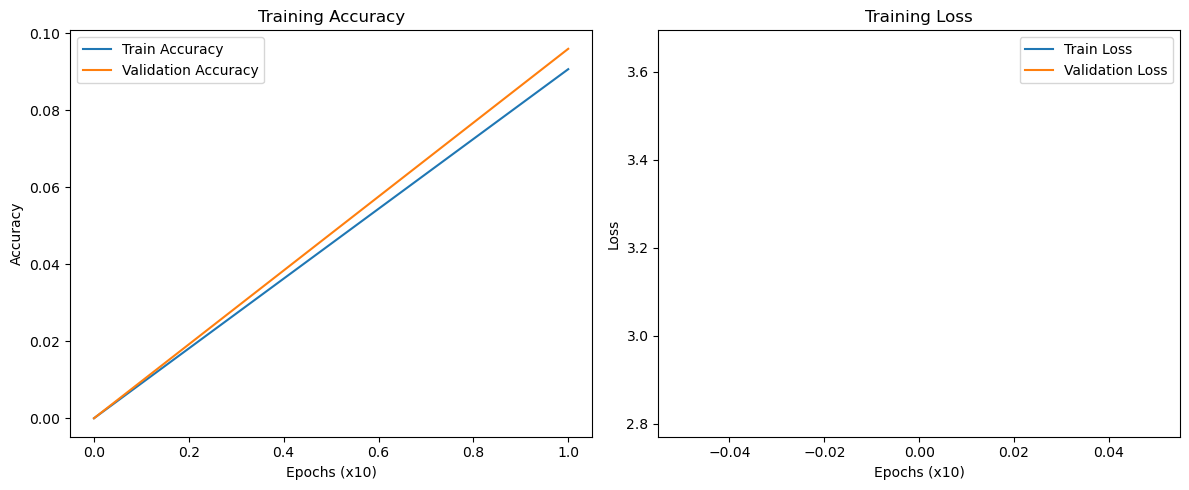

Epoch 10 out of 2000
Epoch 20 out of 2000
Epoch 30 out of 2000
Epoch 40 out of 2000
Epoch 50 out of 2000
Epoch 60 out of 2000
Epoch 70 out of 2000
Epoch 80 out of 2000
Epoch 90 out of 2000
Epoch 100 out of 2000
Train Accuracy: 0.639
Validation Accuracy: 0.662
Train Loss: 1.116
Validation Loss: 1.054


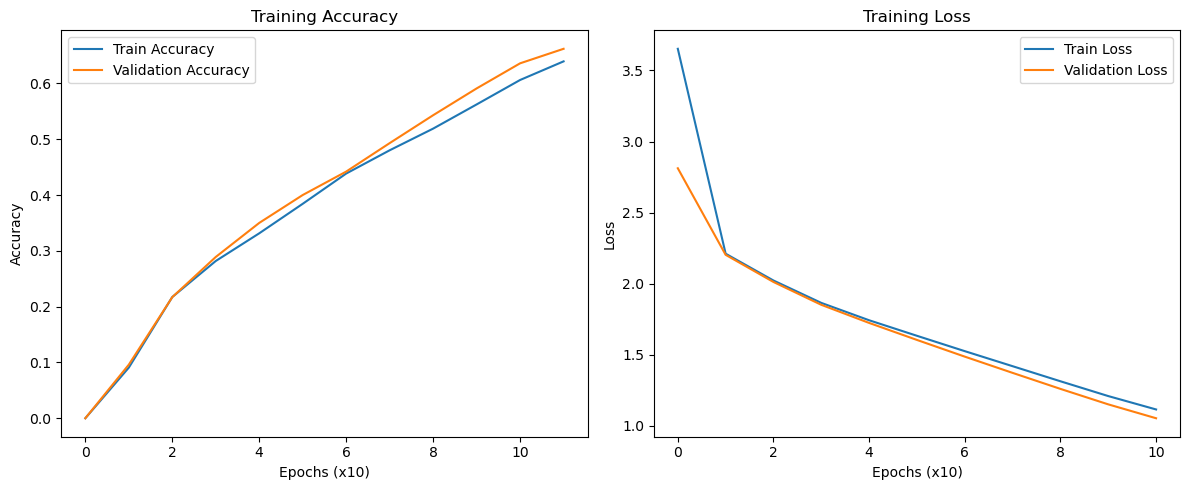

Epoch 110 out of 2000
Epoch 120 out of 2000
Epoch 130 out of 2000
Epoch 140 out of 2000
Epoch 150 out of 2000
Epoch 160 out of 2000
Epoch 170 out of 2000
Epoch 180 out of 2000
Epoch 190 out of 2000
Epoch 200 out of 2000
Train Accuracy: 0.797
Validation Accuracy: 0.806
Train Loss: 0.649
Validation Loss: 0.633


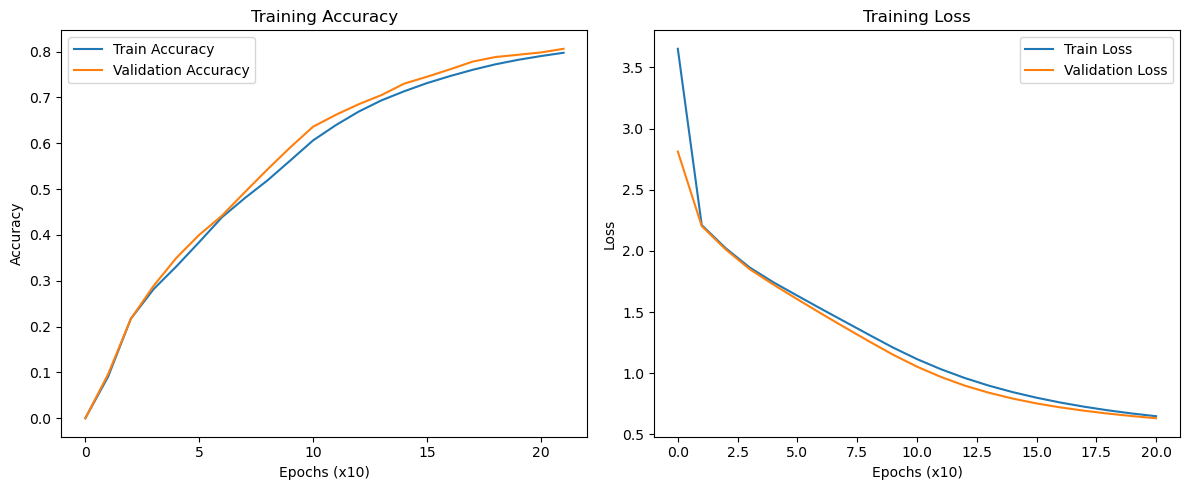

Epoch 210 out of 2000
Epoch 220 out of 2000
Epoch 230 out of 2000
Epoch 240 out of 2000
Epoch 250 out of 2000
Epoch 260 out of 2000
Epoch 270 out of 2000
Epoch 280 out of 2000
Epoch 290 out of 2000
Epoch 300 out of 2000
Train Accuracy: 0.839
Validation Accuracy: 0.840
Train Loss: 0.525
Validation Loss: 0.526


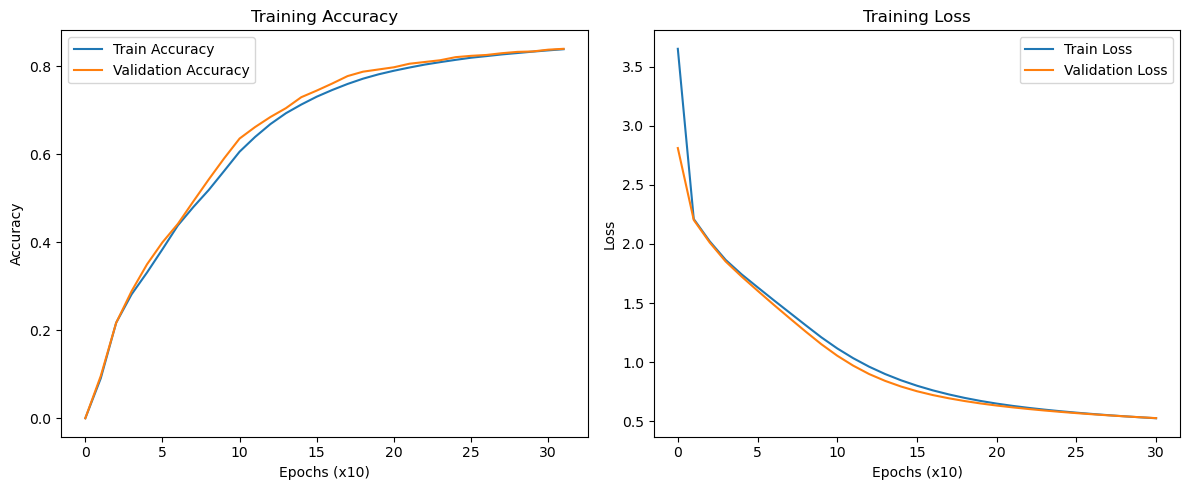

Epoch 310 out of 2000
Epoch 320 out of 2000
Epoch 330 out of 2000
Epoch 340 out of 2000
Epoch 350 out of 2000
Epoch 360 out of 2000
Epoch 370 out of 2000
Epoch 380 out of 2000
Epoch 390 out of 2000
Epoch 400 out of 2000
Train Accuracy: 0.859
Validation Accuracy: 0.872
Train Loss: 0.467
Validation Loss: 0.471


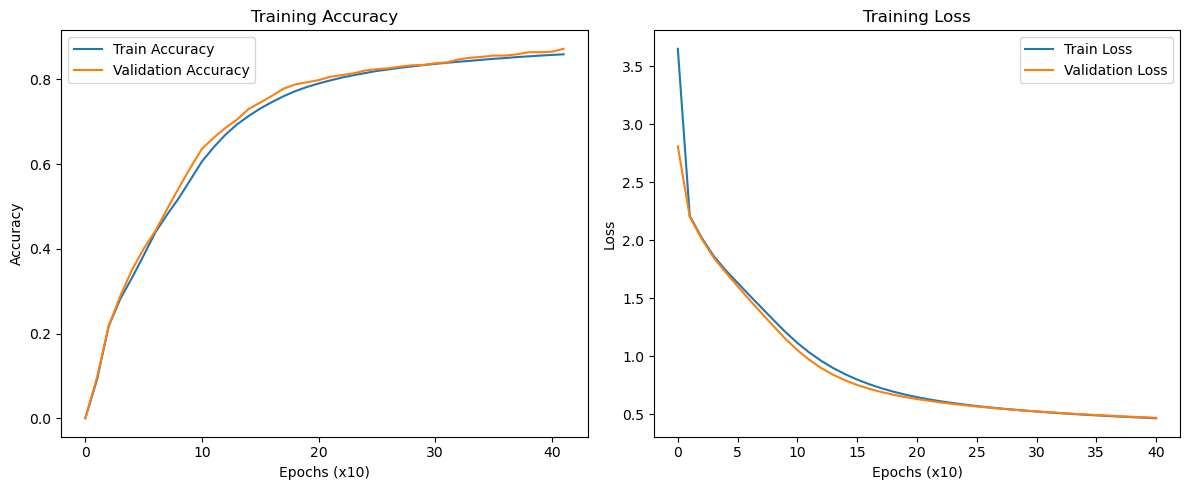

Epoch 410 out of 2000
Epoch 420 out of 2000
Epoch 430 out of 2000
Epoch 440 out of 2000
Epoch 450 out of 2000
Epoch 460 out of 2000
Epoch 470 out of 2000
Epoch 480 out of 2000
Epoch 490 out of 2000
Epoch 500 out of 2000
Train Accuracy: 0.871
Validation Accuracy: 0.878
Train Loss: 0.431
Validation Loss: 0.436


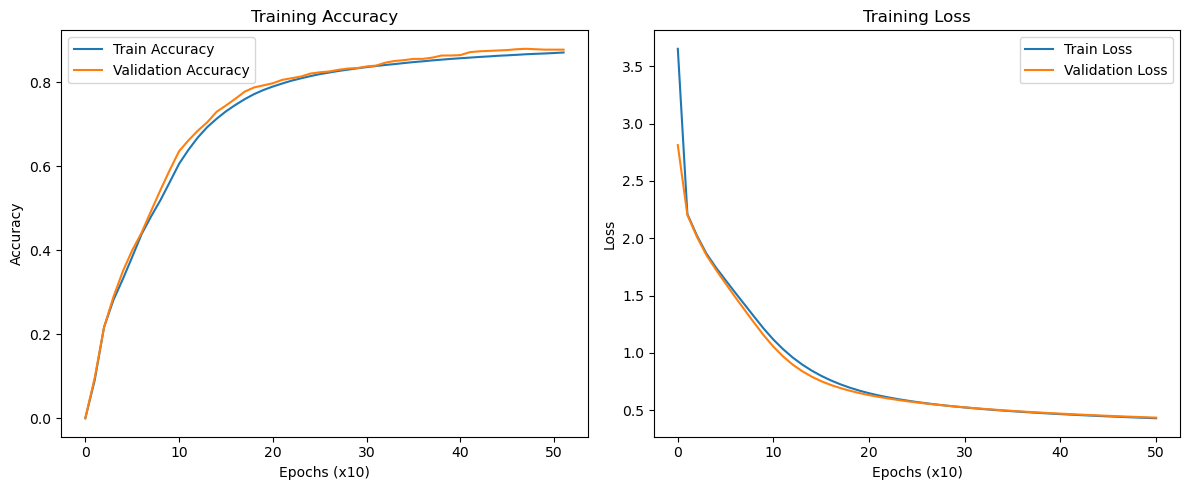

Epoch 510 out of 2000
Epoch 520 out of 2000
Epoch 530 out of 2000
Epoch 540 out of 2000
Epoch 550 out of 2000
Epoch 560 out of 2000
Epoch 570 out of 2000
Epoch 580 out of 2000
Epoch 590 out of 2000
Epoch 600 out of 2000
Train Accuracy: 0.879
Validation Accuracy: 0.888
Train Loss: 0.406
Validation Loss: 0.412


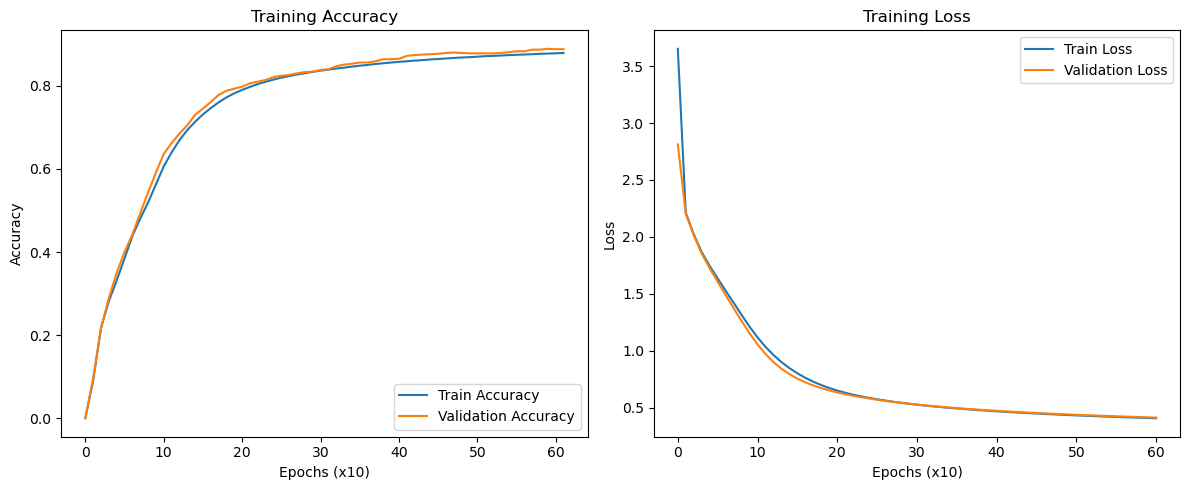

Epoch 610 out of 2000
Epoch 620 out of 2000
Epoch 630 out of 2000
Epoch 640 out of 2000
Epoch 650 out of 2000
Epoch 660 out of 2000
Epoch 670 out of 2000
Epoch 680 out of 2000
Epoch 690 out of 2000
Epoch 700 out of 2000
Train Accuracy: 0.886
Validation Accuracy: 0.890
Train Loss: 0.387
Validation Loss: 0.393


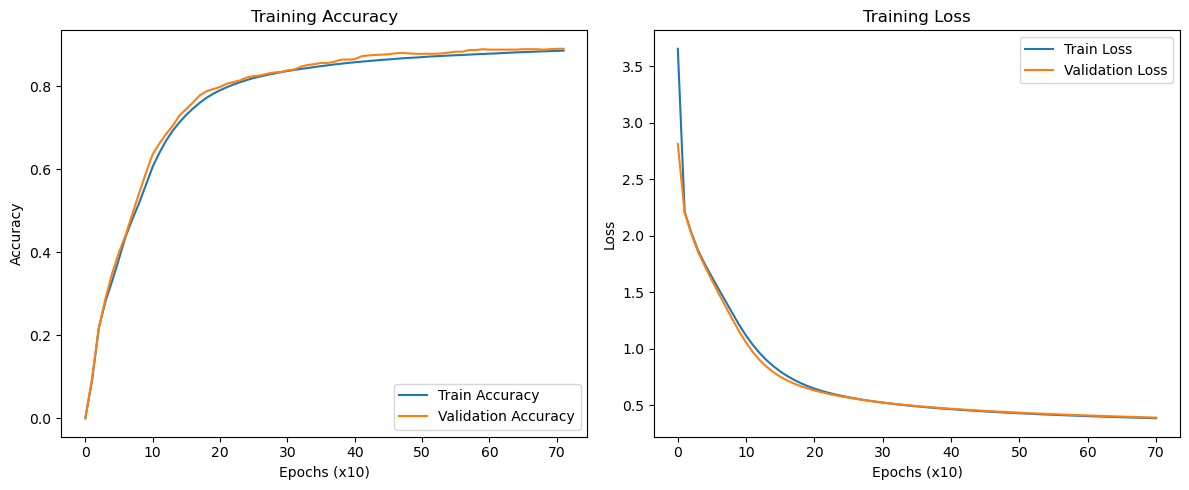

Epoch 710 out of 2000
Epoch 720 out of 2000
Epoch 730 out of 2000
Epoch 740 out of 2000
Epoch 750 out of 2000
Epoch 760 out of 2000
Epoch 770 out of 2000
Epoch 780 out of 2000
Epoch 790 out of 2000
Epoch 800 out of 2000
Train Accuracy: 0.890
Validation Accuracy: 0.892
Train Loss: 0.372
Validation Loss: 0.378


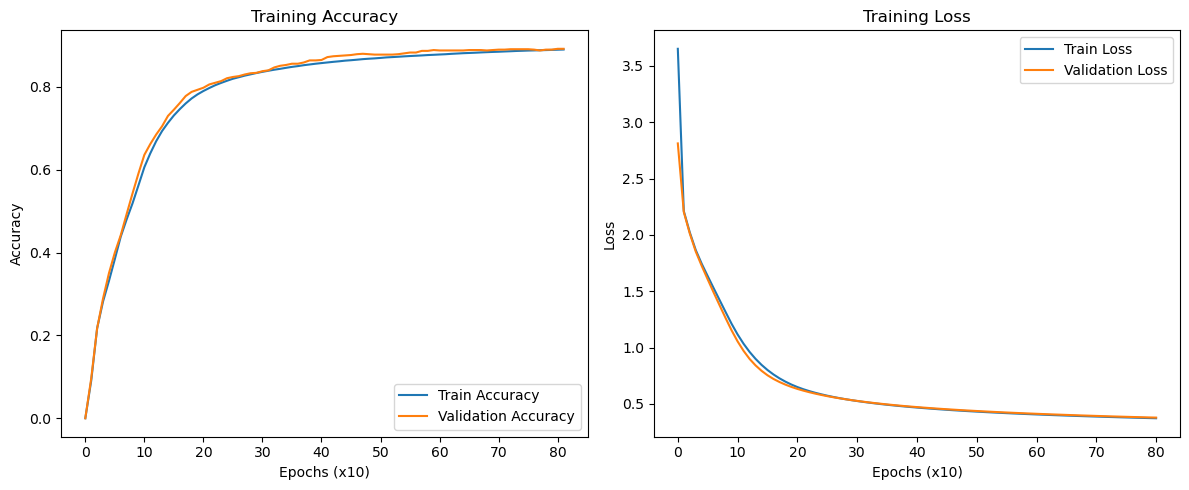

Epoch 810 out of 2000
Epoch 820 out of 2000
Epoch 830 out of 2000
Epoch 840 out of 2000
Epoch 850 out of 2000
Epoch 860 out of 2000
Epoch 870 out of 2000
Epoch 880 out of 2000
Epoch 890 out of 2000
Epoch 900 out of 2000
Train Accuracy: 0.894
Validation Accuracy: 0.896
Train Loss: 0.360
Validation Loss: 0.366


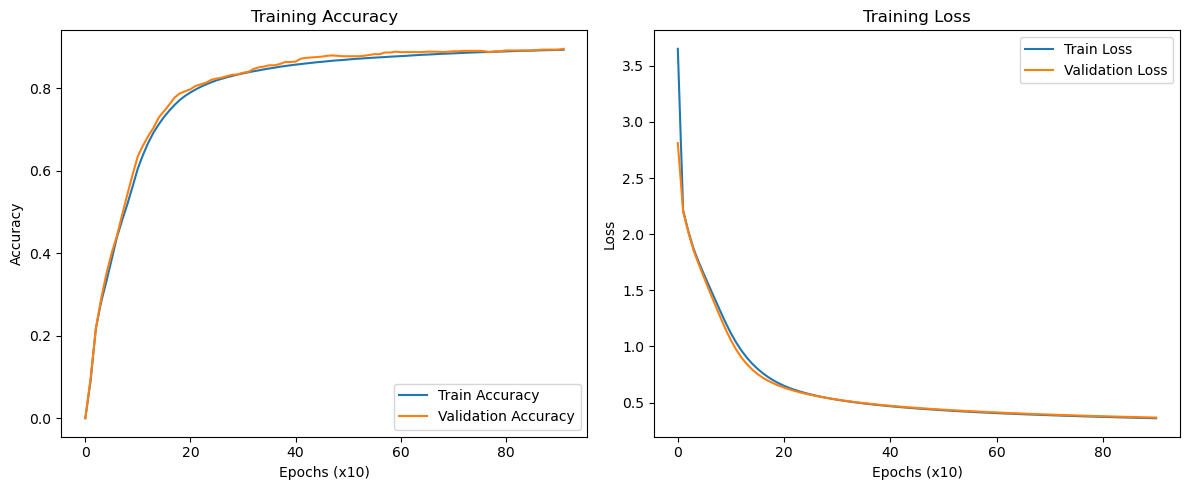

Epoch 910 out of 2000
Epoch 920 out of 2000
Epoch 930 out of 2000
Epoch 940 out of 2000
Epoch 950 out of 2000
Epoch 960 out of 2000
Epoch 970 out of 2000
Epoch 980 out of 2000
Epoch 990 out of 2000
Epoch 1000 out of 2000
Train Accuracy: 0.897
Validation Accuracy: 0.903
Train Loss: 0.350
Validation Loss: 0.357


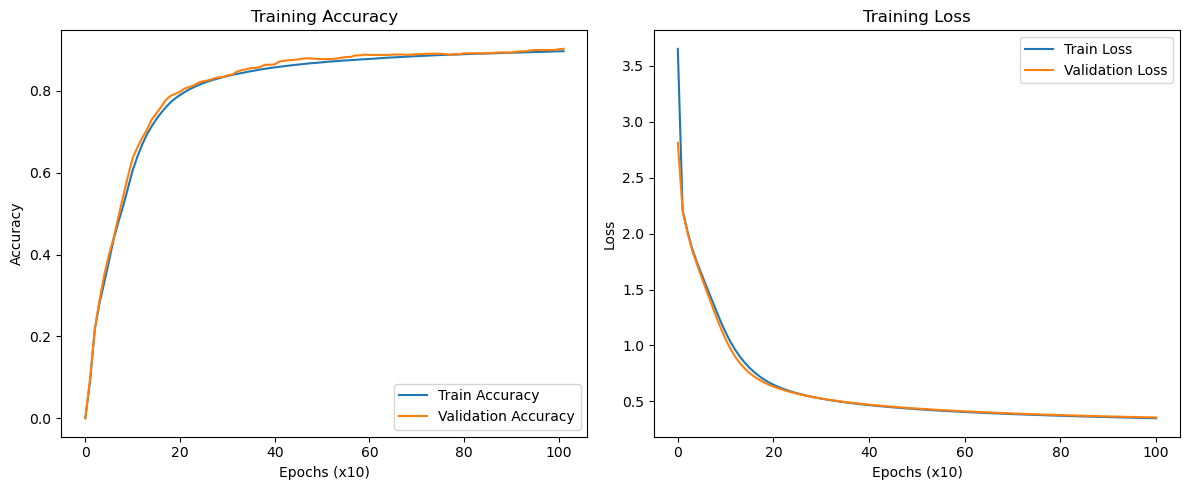

Epoch 1010 out of 2000
Epoch 1020 out of 2000
Epoch 1030 out of 2000
Epoch 1040 out of 2000
Epoch 1050 out of 2000
Epoch 1060 out of 2000
Epoch 1070 out of 2000
Epoch 1080 out of 2000
Epoch 1090 out of 2000
Epoch 1100 out of 2000
Train Accuracy: 0.900
Validation Accuracy: 0.905
Train Loss: 0.341
Validation Loss: 0.348


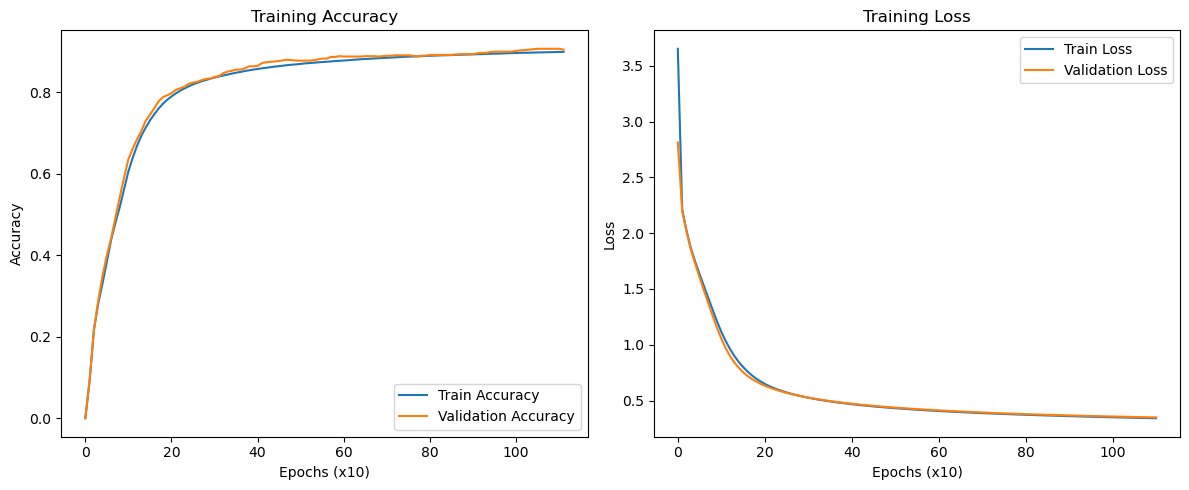

Epoch 1110 out of 2000
Epoch 1120 out of 2000
Epoch 1130 out of 2000
Epoch 1140 out of 2000
Epoch 1150 out of 2000
Epoch 1160 out of 2000
Epoch 1170 out of 2000
Epoch 1180 out of 2000
Epoch 1190 out of 2000
Epoch 1200 out of 2000
Train Accuracy: 0.902
Validation Accuracy: 0.905
Train Loss: 0.333
Validation Loss: 0.341


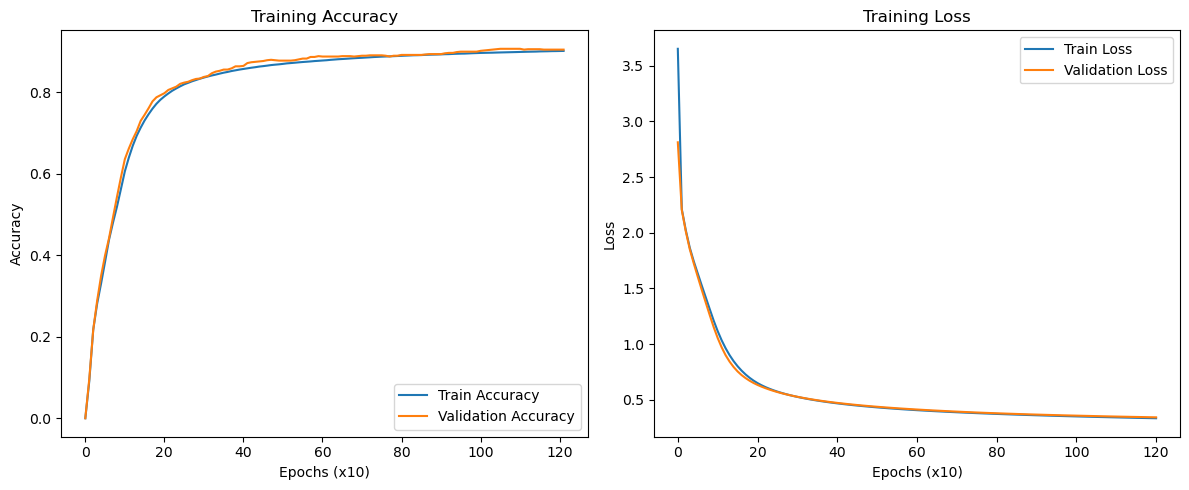

Epoch 1210 out of 2000
Epoch 1220 out of 2000
Epoch 1230 out of 2000
Epoch 1240 out of 2000
Epoch 1250 out of 2000
Epoch 1260 out of 2000
Epoch 1270 out of 2000
Epoch 1280 out of 2000
Epoch 1290 out of 2000
Epoch 1300 out of 2000
Train Accuracy: 0.904
Validation Accuracy: 0.904
Train Loss: 0.326
Validation Loss: 0.335


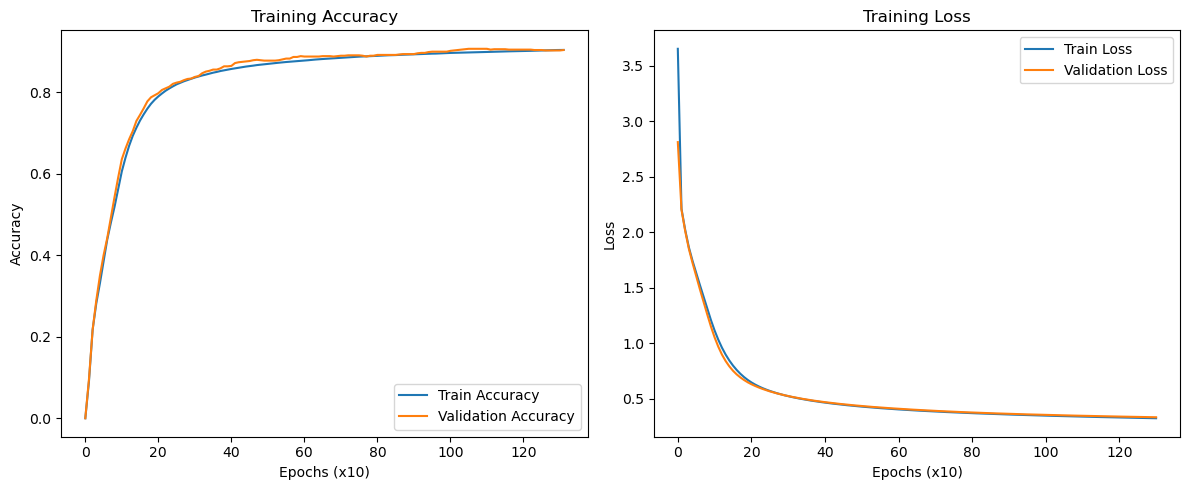

Epoch 1310 out of 2000
Epoch 1320 out of 2000
Epoch 1330 out of 2000
Epoch 1340 out of 2000
Epoch 1350 out of 2000
Epoch 1360 out of 2000
Epoch 1370 out of 2000
Epoch 1380 out of 2000
Epoch 1390 out of 2000
Epoch 1400 out of 2000
Train Accuracy: 0.906
Validation Accuracy: 0.907
Train Loss: 0.320
Validation Loss: 0.330


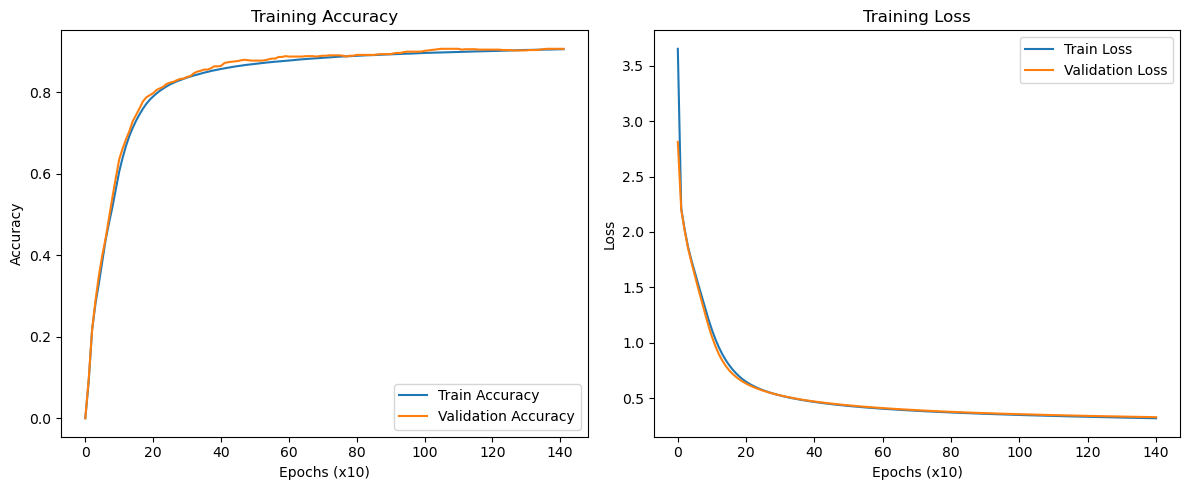

Epoch 1410 out of 2000
Epoch 1420 out of 2000
Epoch 1430 out of 2000
Epoch 1440 out of 2000
Epoch 1450 out of 2000
Epoch 1460 out of 2000
Epoch 1470 out of 2000
Epoch 1480 out of 2000
Epoch 1490 out of 2000
Epoch 1500 out of 2000
Train Accuracy: 0.908
Validation Accuracy: 0.907
Train Loss: 0.315
Validation Loss: 0.325


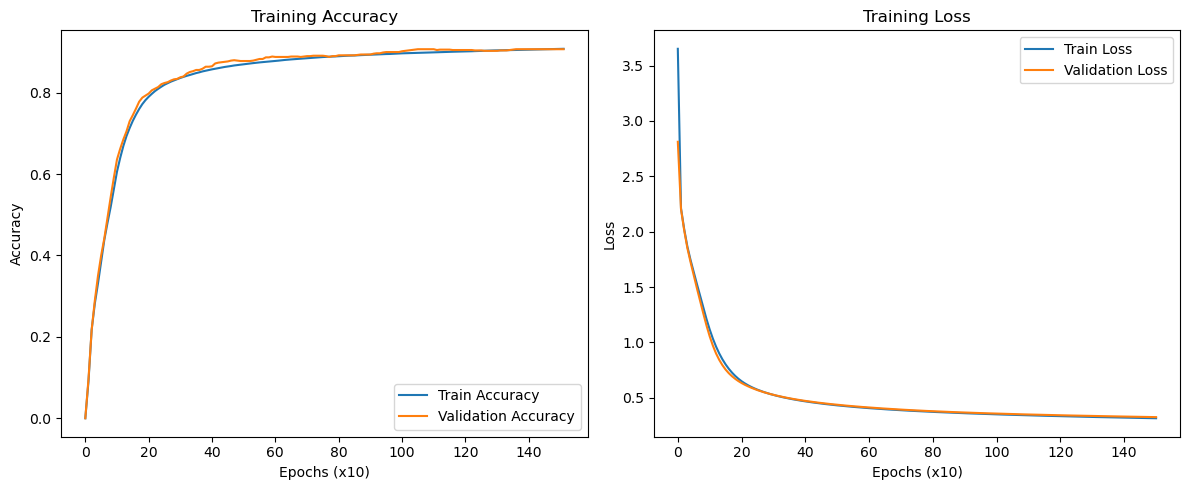

Epoch 1510 out of 2000
Epoch 1520 out of 2000
Epoch 1530 out of 2000
Epoch 1540 out of 2000
Epoch 1550 out of 2000
Epoch 1560 out of 2000
Epoch 1570 out of 2000
Epoch 1580 out of 2000
Epoch 1590 out of 2000
Epoch 1600 out of 2000
Train Accuracy: 0.909
Validation Accuracy: 0.907
Train Loss: 0.309
Validation Loss: 0.320


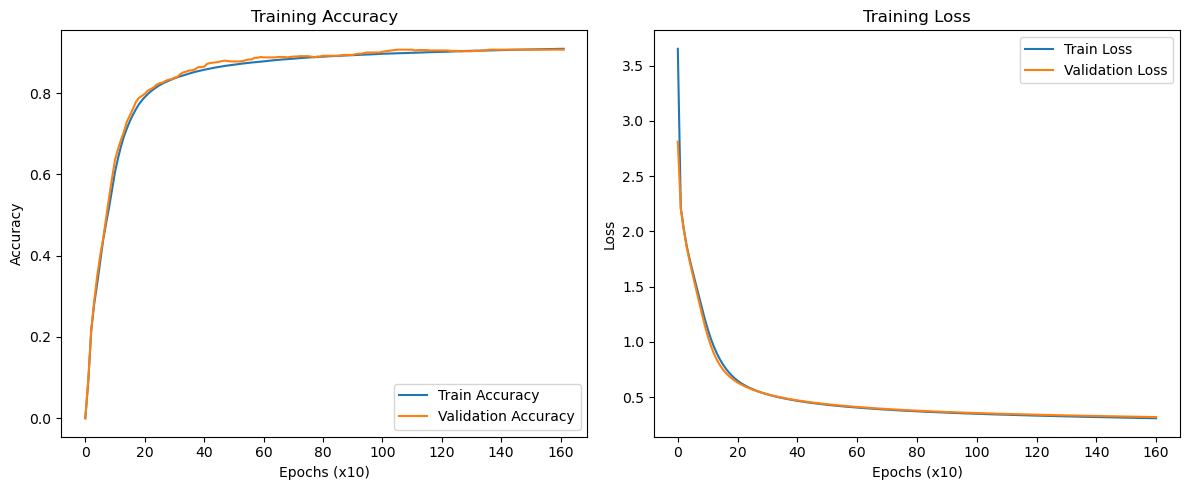

Epoch 1610 out of 2000
Epoch 1620 out of 2000
Epoch 1630 out of 2000
Epoch 1640 out of 2000
Epoch 1650 out of 2000
Epoch 1660 out of 2000
Epoch 1670 out of 2000
Epoch 1680 out of 2000
Epoch 1690 out of 2000
Epoch 1700 out of 2000
Train Accuracy: 0.911
Validation Accuracy: 0.905
Train Loss: 0.305
Validation Loss: 0.316


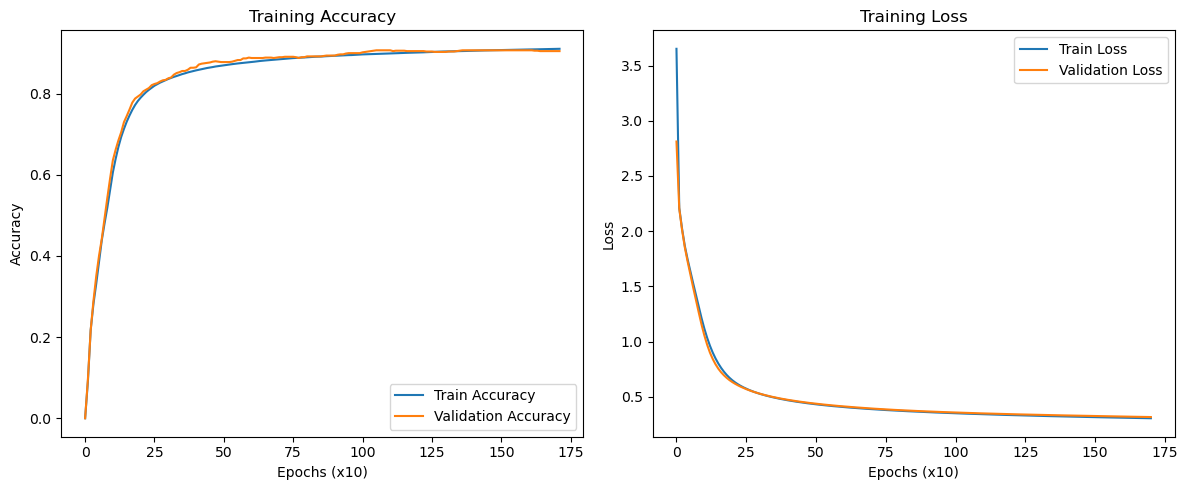

Epoch 1710 out of 2000
Epoch 1720 out of 2000
Epoch 1730 out of 2000
Epoch 1740 out of 2000
Epoch 1750 out of 2000
Epoch 1760 out of 2000
Epoch 1770 out of 2000
Epoch 1780 out of 2000
Epoch 1790 out of 2000
Epoch 1800 out of 2000
Train Accuracy: 0.912
Validation Accuracy: 0.907
Train Loss: 0.300
Validation Loss: 0.312


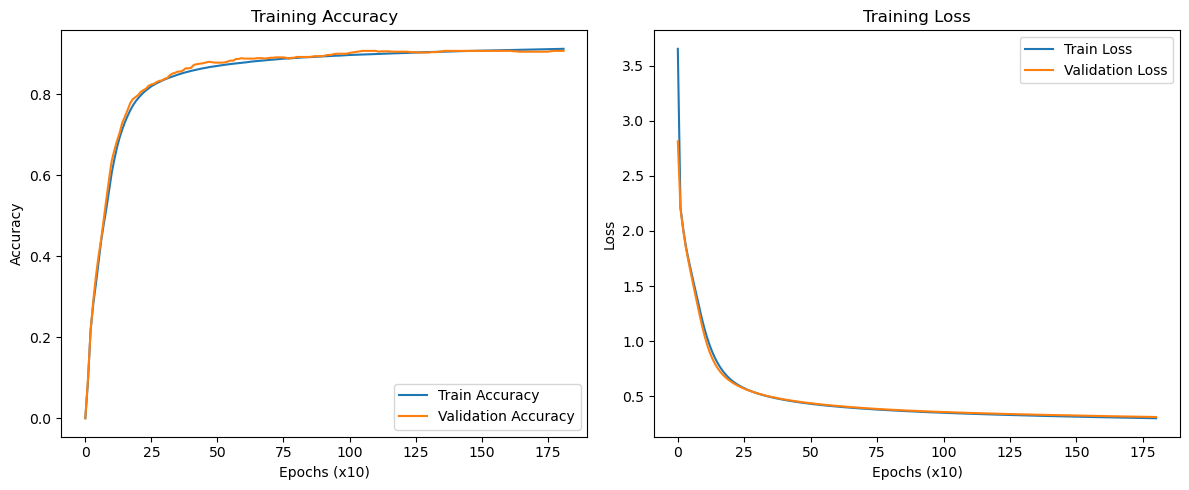

Epoch 1810 out of 2000
Epoch 1820 out of 2000
Epoch 1830 out of 2000
Epoch 1840 out of 2000
Epoch 1850 out of 2000
Epoch 1860 out of 2000
Epoch 1870 out of 2000
Epoch 1880 out of 2000
Epoch 1890 out of 2000
Epoch 1900 out of 2000
Train Accuracy: 0.914
Validation Accuracy: 0.907
Train Loss: 0.296
Validation Loss: 0.308


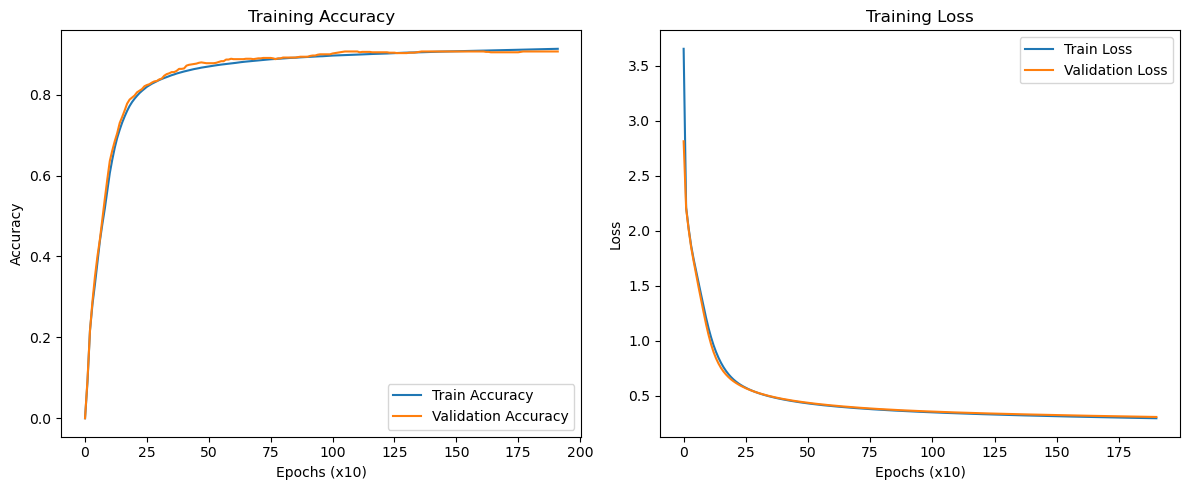

Epoch 1910 out of 2000
Epoch 1920 out of 2000
Epoch 1930 out of 2000
Epoch 1940 out of 2000
Epoch 1950 out of 2000
Epoch 1960 out of 2000
Epoch 1970 out of 2000
Epoch 1980 out of 2000
Epoch 1990 out of 2000
Training completed in 2773.86 seconds.


In [9]:
# Perform NN training
W1, b1, W2, b2 = gradient_descent(values_train, labels_train, EPOCHS, ALPHA, values_validation, labels_validation)


In [10]:
def evaluate_model(W1, b1, W2, b2, values, labels):
    _, _, _, A2 = forward_propagation(W1, b1, W2, b2, values)
    predictions = get_predictions(A2)
    accuracy = get_accuracy(predictions, labels)
    loss = cross_entropy_loss(A2, one_hot(labels))

    return accuracy, loss

accuracy_train, loss_train = evaluate_model(W1, b1, W2, b2, values_train, labels_train)
accuracy_validation, loss_validation = evaluate_model(W1, b1, W2, b2, values_validation, labels_validation)
accuracy_test, loss_test = evaluate_model(W1, b1, W2, b2, values_test, labels_test)

print(f"Train Accuracy: {accuracy_train:.3f}")
print(f"Train Loss: {loss_train:.3f}")
print(f"Validation Accuracy: {accuracy_validation:.3f}")
print(f"Validation Loss: {loss_validation:.3f}")
print(f"Test Accuracy: {accuracy_test:.3f}")
print(f"Test Loss: {loss_test:.3f}")


Train Accuracy: 0.915
Train Loss: 0.292
Validation Accuracy: 0.908
Validation Loss: 0.304
Test Accuracy: 0.911
Test Loss: 0.342


In [11]:
def calculate_parameters(W1, b1, W2, b2):
    parameters_count = W1.size + b1.size + W2.size + b2.size
    return parameters_count

parameters_count = calculate_parameters(W1, b1, W2, b2)
print(f"Total Trainable Parameters: {parameters_count}")

Total Trainable Parameters: 7960
